In [1]:
# --- Bibliotecas Essenciais ---
import pandas as pd
import numpy as np
import joblib # Para salvar o modelo

# --- Bibliotecas para Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Bibliotecas para Análise Estatística ---
from scipy import stats

# --- Bibliotecas do Scikit-learn para Pré-processamento e Modelagem ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# --- Modelos de Regressão ---
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# --- Métricas de Avaliação ---
from sklearn.metrics import mean_squared_error, r2_score

# --- Configurações de Visualização ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


In [2]:
# Carregamento da base de dados
url = "https://raw.githubusercontent.com/josenalde/machinelearning/main/src/dataset/housing.csv"
df = pd.read_csv(url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 1. Análise Exploratória de Dados (AED)

O primeiro passo em qualquer projeto de Machine Learning é entender profundamente os dados. [cite_start]Nesta seção, vamos realizar uma análise exploratória para analisar as features originais, observar seus limites e distribuições[cite: 39, 40].

In [3]:
print("Informações Gerais do DataFrame:")
df.info()

print("\nEstatísticas Descritivas:")
print(df.describe())

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Estatísticas Descritivas:
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.63

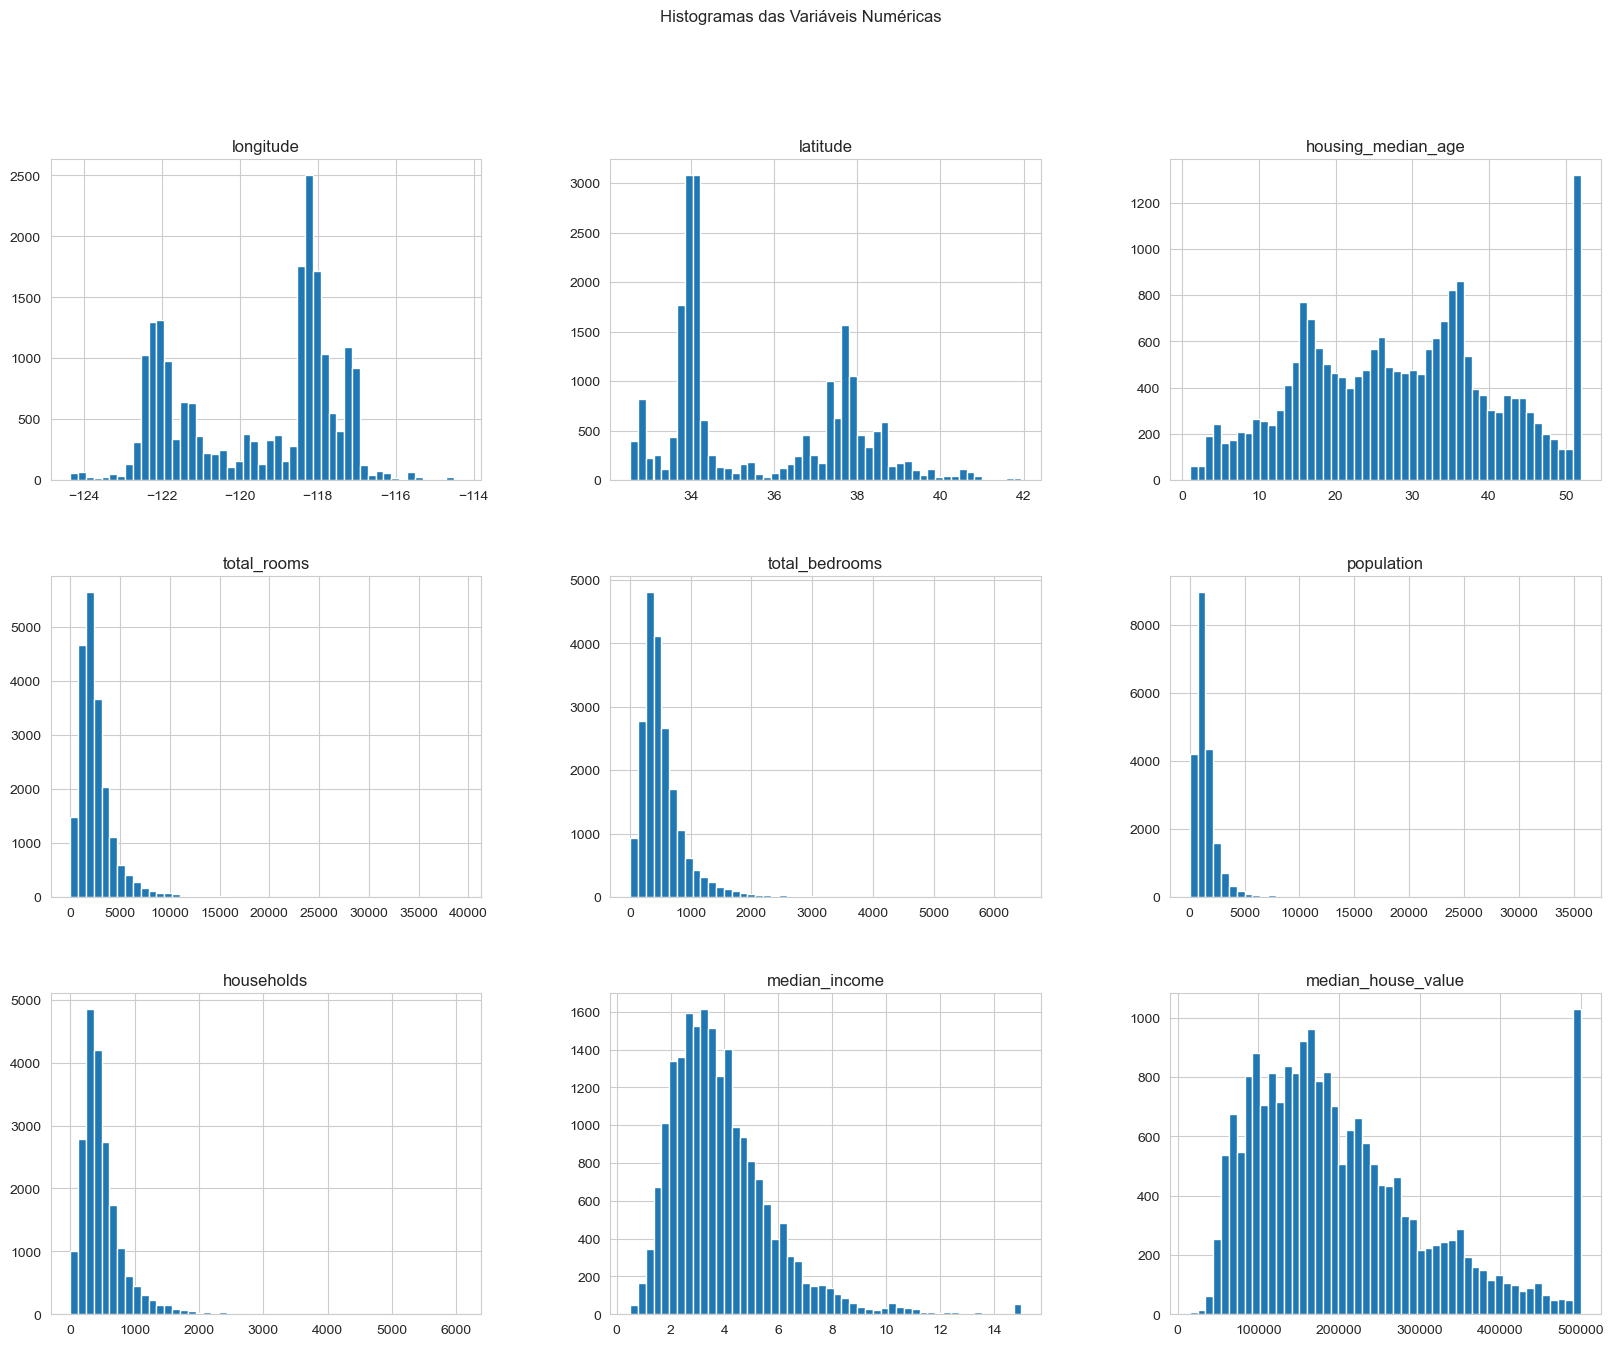

In [4]:
# [cite_start]Gerar histogramas das features numéricas para observar suas distribuições [cite: 40]
df.hist(bins=50, figsize=(20, 15))
plt.suptitle("Histogramas das Variáveis Numéricas")
plt.show()

Os histogramas mostram que muitas variáveis, como `total_rooms` e `population`, são assimétricas e não seguem uma distribuição normal. A variável alvo `median_house_value` também parece ter um limite em 500.000.

## 2. Engenharia de Features e Análise de Correlação

[cite_start]Com base na análise inicial, vamos criar novas features para tentar capturar relações mais complexas e potencializar o modelo preditivo[cite: 41]. Em seguida, analisaremos a correlação dessas features com a nossa variável alvo.

In [8]:
# Tratamento de valores faltosos antes de criar novas features
df['total_bedrooms'] = df['total_bedrooms'].fillna(df['total_bedrooms'].mean())

# [cite_start]Criação de novas features [cite: 41]
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

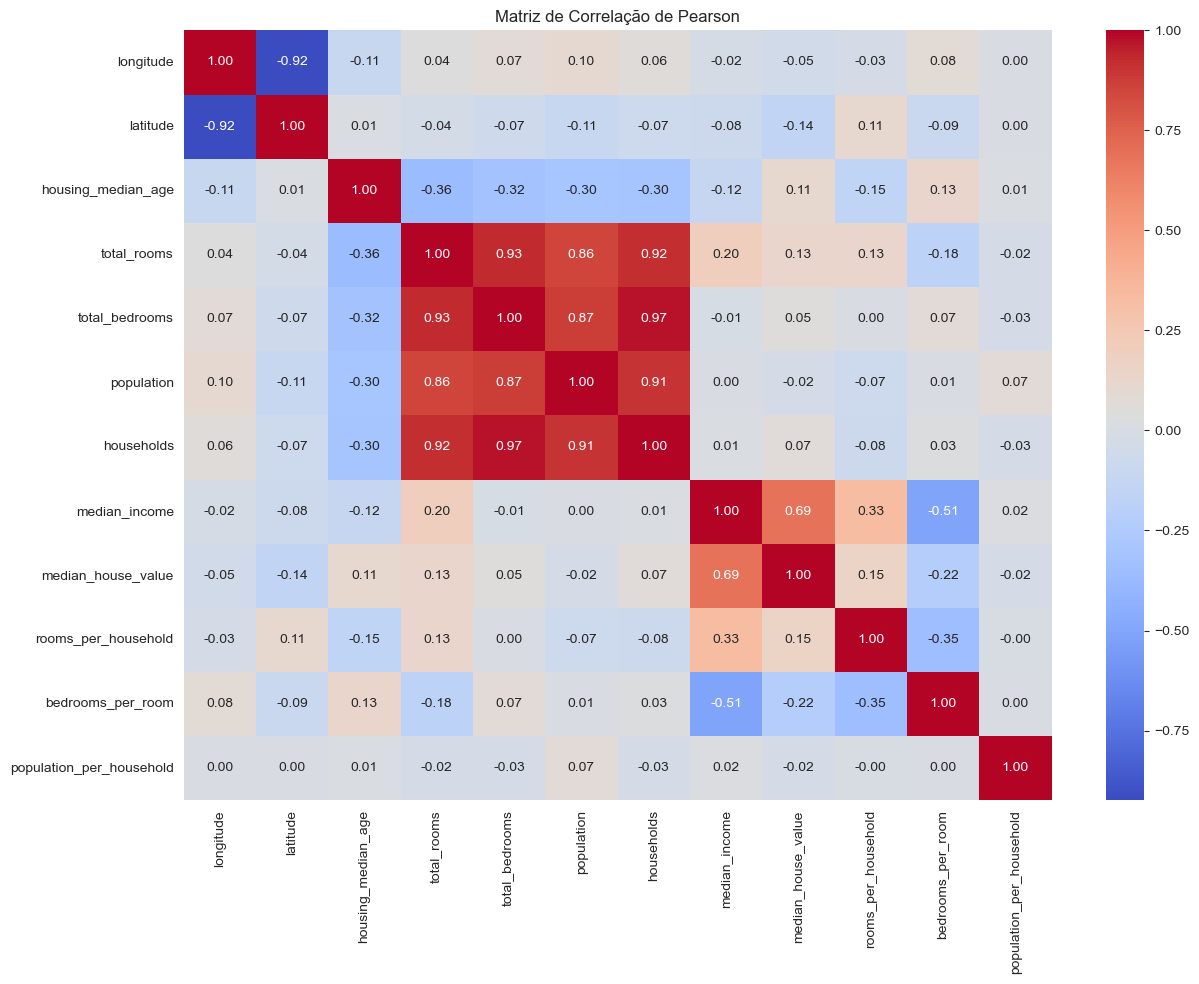


5 Features mais correlacionadas com 'median_house_value':
median_income          0.688075
bedrooms_per_room      0.220049
rooms_per_household    0.151948
latitude               0.144160
total_rooms            0.134153
Name: median_house_value, dtype: float64


In [9]:
# [cite_start]Obter a matriz de correlação [cite: 42]
corr_matrix = df.corr(numeric_only=True)

# Visualizar a matriz com um heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação de Pearson')
plt.show()

# [cite_start]Listar as 5 features mais correlacionadas com a variável alvo [cite: 42]
print("\n5 Features mais correlacionadas com 'median_house_value':")
print(corr_matrix['median_house_value'].abs().sort_values(ascending=False).drop('median_house_value').head(5))

## 3. Análise Estatística Aprofundada

Para validar visualmente a presença de outliers e testar formalmente algumas hipóteses que surgiram na análise exploratória, mantemos esta seção estatística.

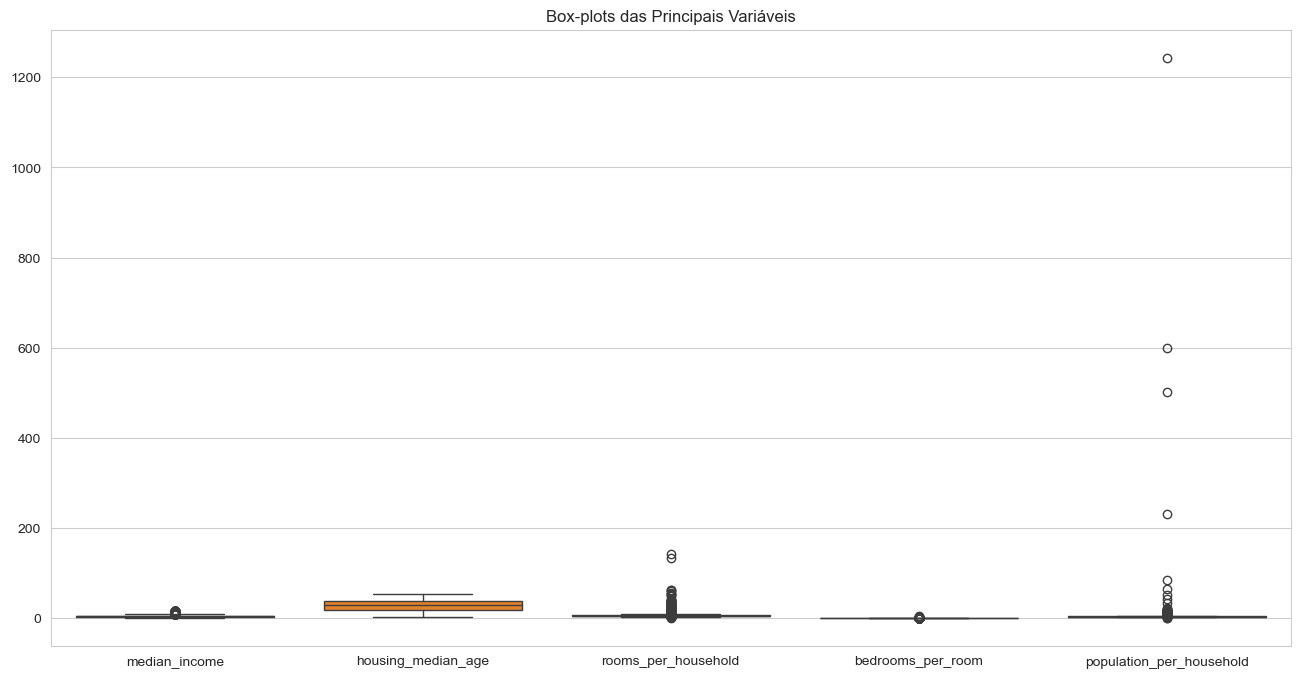

In [10]:
# Apresentar box-plots para investigar a presença de valores atípicos
colunas_num = ['median_income', 'housing_median_age', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[colunas_num])
plt.title('Box-plots das Principais Variáveis')
plt.show()

Os box-plots confirmam a presença de muitos outliers, o que reforça a necessidade de usar modelos robustos, como o Random Forest.

## 4. Pré-processamento dos Dados

Esta é uma das etapas mais críticas. Vamos preparar os dados para o treinamento do modelo, o que inclui a divisão em conjuntos de treino e teste e a criação de um pipeline de transformação.

In [12]:
# [cite_start]Criar uma feature temporária de renda para divisão estratificada [cite: 43]
df['income_cat'] = pd.cut(df['median_income'],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

# Separar features (X) e target (y)
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# [cite_start]Realizar a divisão do conjunto de dados em 80% para treino e 20% para teste [cite: 45, 46]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['income_cat']
)

# Remover a coluna temporária 'income_cat'
for set_ in (X_train, X_test):
    set_.drop('income_cat', axis=1, inplace=True)

## 5. Construção do Pipeline de Modelagem

[cite_start]Para garantir que as mesmas transformações sejam aplicadas de forma consistente nos dados de treino e teste, construiremos um Pipeline que agrega todas as etapas de pré-processamento[cite: 51].

In [13]:
# Identificar colunas numéricas e categóricas
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Criar o pipeline de pré-processamento
# Este pipeline irá:
# [cite_start]1. Preencher valores ausentes com a média (SimpleImputer) [cite: 47]
# [cite_start]2. Aplicar padronização às colunas numéricas (StandardScaler) [cite: 48]
# [cite_start]3. Aplicar codificação às colunas categóricas (OneHotEncoder e OrdinalEncoder) [cite: 49]

# Pipeline para features numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para features categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Usar ColumnTransformer para aplicar diferentes transformações a diferentes colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## 6. Treinamento, Otimização e Comparação de Modelos

[cite_start]Nesta fase, vamos treinar, otimizar com Grid Search e comparar o desempenho de múltiplos modelos de regressão, incluindo os modelos de regularização L1, L2 e ElasticNet[cite: 52, 55].

In [16]:
# Definir os modelos a serem testados
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Definir os parâmetros para o Grid Search
param_grids = {
    'Linear Regression': {},
    'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
    'ElasticNet': {'regressor__alpha': [0.1, 1.0], 'regressor__l1_ratio': [0.5, 0.9]},
    'Decision Tree': {'regressor__max_depth': [10, 20, None]},
    'Random Forest': {'regressor__n_estimators': [100, 200], 'regressor__max_depth': [10, 20]}
}

results = {}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    print(f"--- Treinando {name} ---")
    # Criar o pipeline completo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Executar Grid Search
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Salvar resultados
    results[name] = {
        'best_score (R2)': grid_search.best_score_,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    }

# Exibir os resultados
results_df = pd.DataFrame(results).T.sort_values(by='best_score (R2)', ascending=False)
print("\n--- Tabela Comparativa de Desempenho dos Modelos ---")
print(results_df[['best_score (R2)', 'best_params']])

--- Treinando Linear Regression ---
--- Treinando Lasso ---
--- Treinando Ridge ---
--- Treinando ElasticNet ---
--- Treinando Decision Tree ---
--- Treinando Random Forest ---

--- Tabela Comparativa de Desempenho dos Modelos ---
                  best_score (R2)  \
Random Forest            0.809247   
Decision Tree            0.702786   
Ridge                    0.641914   
Lasso                    0.641882   
Linear Regression        0.641841   
ElasticNet               0.641674   

                                                         best_params  
Random Forest      {'regressor__max_depth': 20, 'regressor__n_est...  
Decision Tree                           {'regressor__max_depth': 10}  
Ridge                                     {'regressor__alpha': 10.0}  
Lasso                                     {'regressor__alpha': 10.0}  
Linear Regression                                                 {}  
ElasticNet         {'regressor__alpha': 0.1, 'regressor__l1_ratio...  


## 7. Avaliação Final e Salvamento do Melhor Modelo

Com base na tabela comparativa, o **Random Forest** foi o modelo com o melhor desempenho. [cite_start]Agora, vamos aplicar este modelo final no conjunto de teste para avaliar sua performance real [cite: 54] e, em seguida, salvá-lo para ser usado em nossa aplicação web.

In [17]:
# Selecionar o melhor modelo
best_model_name = results_df.index[0]
best_model_pipeline = results[best_model_name]['best_estimator']

print(f"Melhor modelo: {best_model_name}")

# Fazer predições no conjunto de teste
y_pred = best_model_pipeline.predict(X_test)

# Calcular as métricas finais
final_r2 = r2_score(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)

print(f"\n--- Performance Final no Conjunto de Teste ---")
print(f"R² (Coeficiente de Determinação): {final_r2:.4f}")
print(f"MSE (Erro Quadrático Médio): {final_mse:.2f}")

Melhor modelo: Random Forest

--- Performance Final no Conjunto de Teste ---
R² (Coeficiente de Determinação): 0.8217
MSE (Erro Quadrático Médio): 2323837703.48


In [18]:
# Salvar o pipeline completo do melhor modelo em um arquivo
# [cite_start]Este arquivo será usado pela aplicação web [cite: 77]
joblib.dump(best_model_pipeline, 'housing_regression_model.pkl')

print("\nModelo 'housing_regression_model.pkl' salvo com sucesso na pasta do projeto!")


Modelo 'housing_regression_model.pkl' salvo com sucesso na pasta do projeto!


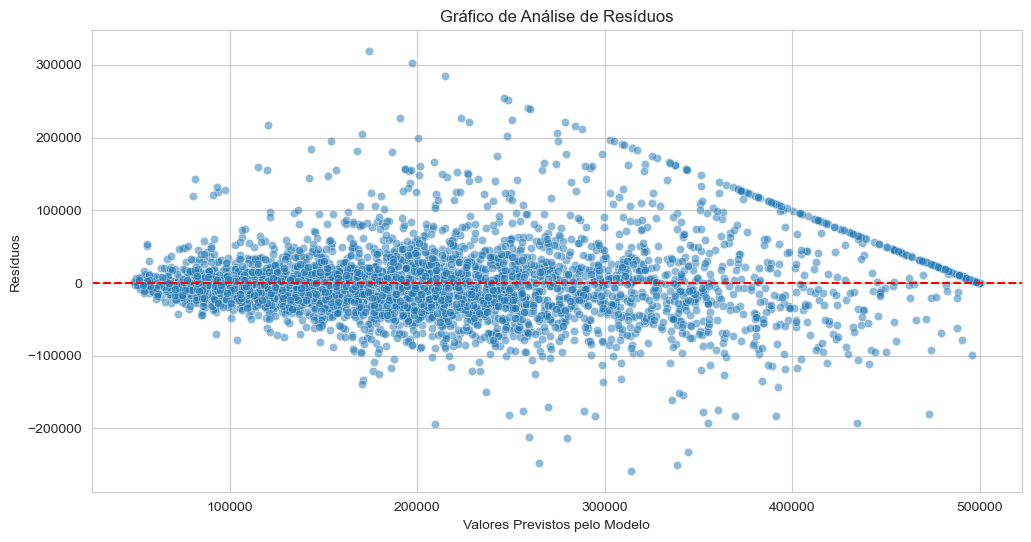

In [19]:
# Análise de Pressupostos: Gráfico de Resíduos

# Resíduos = Valor Real - Valor Previsto
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Previstos pelo Modelo")
plt.ylabel("Resíduos")
plt.title("Gráfico de Análise de Resíduos")
plt.show()

### Análise dos Resíduos do Modelo

O gráfico de resíduos acima nos ajuda a verificar um dos pressupostos do modelo de regressão: a **homocedasticidade**, ou seja, se a variância dos erros é constante.

Observamos que os pontos estão espalhados de forma aleatória em torno da linha horizontal em zero, sem formar um padrão claro (como um funil ou uma curva). Isso é um bom sinal, sugerindo que o modelo se ajustou bem aos dados e que não há uma violação clara dos seus pressupostos.